# Introduction aux autoencodeurs

## Apprentissage supervisé et non supervisé

### Apprentissage supervisé

Dans les cours précédents, nous avons uniquement abordé des cas d'apprentissage supervisé. Pour faire simple, ce sont les cas où, dans les données d'entraînement, on possède un élèment d'entrée **x** et une sortie **y**. Le but du modèle sera alors de prendre **x** en entrée et de prédire la valeur de **y**.  
Pour MNIST, nous avions une image **x** et un label y correspondant à un chiffre en 0 et 9. Pour la segmentation, on avait une image **x** et un masque **y** en sortie. 

### Apprentissage non supervisé

Dans le cas de l'apprentissage non supervisé, nous avons des données non labelisées c'est à dire qu'on a le **x** mais pas le **y**. Dans ce cas, il ne sera pas possible de prédire une valeur bien définie par exemple mais on peut imaginer entraîner un modèle à regrouper des éléments semblables (c'est ce qu'on appelle le clustering).   
Dans ce cours, nous allons plutôt nous intéresser à la détection d'anomalies non supervisées. Cela va consister à entraîner un modèle sur un certain type de données et utiliser ce modèle pour détecter des élèments qui seraient distincts du jeu de données d'entraînement. 

## Autoencodeur

### Architecture

Le modèle de base utilisé pour ce type de tâches se nomme "autoencodeur". Il a une architecture propre du modèle U-Net que l'on a vu dans le cours précédent.  
Voici l'architecture classique d'un autoencodeur :  
<img src="images/AE.png" alt="AE" width="600"/>

Comme vous pouvez le voir, il a une forme de "sablier". L'idée de l'autoencodeur est de créer une representation compressée de la données d'entrée et de la reconstruire à partir de cette representation compressée. On peut d'ailleurs utiliser ce modèle dans un objectif de compression de données.   

### Utilisation pour la détection d'anomalies non supervisée

Pour la détection d'anomalies non supervisée, prenons un exemple de ce qu'il va se passer. On entraîne notre autoencodeur à reconstruire des images du chiffre 5 pendant l'entraînement. Une fois que le modèle est entraîné, il pourra reconstruire une image de 5 à la perfection. Si notre objectif est de détecter si une image est une image de 5 ou une image d'un autre chiffre, il suffit de donner l'image à notre autoencodeur et en fonction de la qualité de la reconstruction ($image_{base} - image_{recons}$), on pourra savoir si il s'agit d'un 5 ou non.   
L'image suivante illustre cette description :  
<img src="images/AE_mnist.png" alt="AE" width="600"/>

## Application pratique sur MNIST

Pour clarifier la description précédente, nous allons entraîner le modèle autoencodeur de reconstruction des 5 avec Pytorch. 

In [225]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision import datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Pour la reproducibilité
np.random.seed(1337)
random.seed(1337)

### Création des datasets d'entraînement et de test

In [226]:
transform=T.ToTensor() # Pour convertir les éléments en tensor torch directement
dataset = datasets.MNIST(root='./../data', train=True, download=True,transform=transform)
test_dataset = datasets.MNIST(root='./../data', train=False,transform=transform)

Nous avons récuperé nos dataset de train/val et de test. On cherche à ne garder que les 5 dans notre dataset d'entraînement. Pour cela, supprimons les éléments du dataset qui contiennent un chiffre différent de 5.

In [227]:
# On récupere les indices des images de 5
indices = [i for i, label in enumerate(dataset.targets) if label == 5]
# On créer un nouveau dataset avec uniquement les 5
filtered_dataset = torch.utils.data.Subset(dataset, indices)

On peut visualiser quelques images pour s'assurer que l'on a bien que des images de 5.

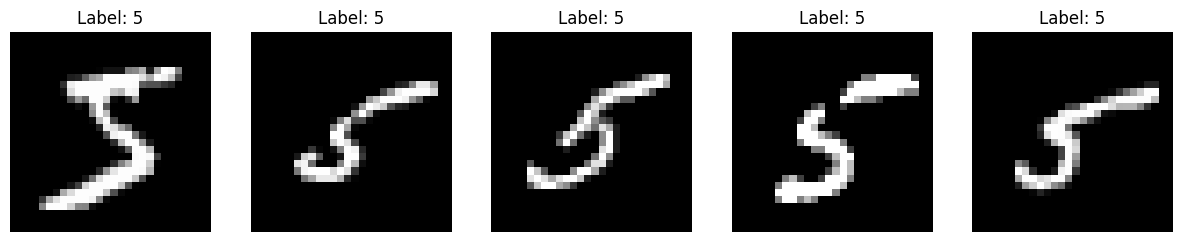

In [228]:
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    image, label = filtered_dataset[i]
    image = image.squeeze().numpy() 
    axes[i].imshow(image, cmap='gray')
    axes[i].set_title(f'Label: {label}')
    axes[i].axis('off')
plt.show()

Divisons maintenant le dataset en train et validation puis créons nos dataloaders.

In [229]:
train_dataset, validation_dataset=torch.utils.data.random_split(filtered_dataset, [0.8,0.2])
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader= DataLoader(validation_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

### Création du modèle autoencodeur

Pour la dataset MNIST, il n'est pas nécessaire de faire une architecture très profonde pour avoir des résultats satisfaisants. Comme il s'agit d'images, nous utilisons un réseau convolutif. 

In [241]:
class ae(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)

        self.encoder = nn.Sequential( # Sequential permet de groupe une série de transformation
            nn.Linear(28 * 28, 512), 
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 28 * 28),
            nn.Sigmoid()
        )
    
    def forward(self,x):
        x=x.view(-1,28*28) 
        x = self.encoder(x)
        x = self.decoder(x)
        recons=x.view(-1,28,28)
        return recons

In [242]:
model = ae() # Couches d'entrée de taille 2, deux couches cachées de 16 neurones et un neurone de sortie
print(model)
print("Nombre de paramètres", sum(p.numel() for p in model.parameters()))

ae(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=784, bias=True)
    (5): Sigmoid()
  )
)
Nombre de paramètres 1132944


### Entraînement du modèle

Pour la fonction de loss, nous utilisons la fonction MSELoss qui est la perte quadratique moyenne définie comme ceci :  
$\text{MSE} = \frac{1}{N} \sum_{i=1}^{N} (y_i - \hat{y}_i)^2$  
où $N$ est le nombre total de pixels dans l'image, $y_i$ est la valeur du pixel $i$ dans l'image originale, et $\hat{y}_i$ est la valeur du pixel $i$ dans l'image reconstruite. C'est une fonction classique pour quantifier la qualité d'une reconstruction. 

In [243]:
criterion = nn.MSELoss()
epochs=10
learning_rate=0.001
optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate)

In [244]:
for i in range(epochs):
    loss_train=0
    for images, _ in train_loader:
        recons=model(images)
        loss=criterion(recons,images)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_train+=loss   
    if i % 1 == 0:
        print(f"step {i} train loss {loss_train/len(train_loader)}")
    loss_val=0    
    for images, _ in val_loader:
        with torch.no_grad():
            recons=model(images)
            loss=criterion(recons,images)
            loss_val+=loss 
    if i % 1 == 0:
        print(f"step {i} val loss {loss_val/len(val_loader)}")

step 0 train loss 0.0833301916718483
step 0 val loss 0.061610087752342224
step 1 train loss 0.061474427580833435
step 1 val loss 0.06109720095992088
step 2 train loss 0.06124737113714218
step 2 val loss 0.06094793602824211
step 3 train loss 0.06107489392161369
step 3 val loss 0.06083217263221741
step 4 train loss 0.061055995523929596
step 4 val loss 0.06091909483075142
step 5 train loss 0.06111642345786095
step 5 val loss 0.060805924236774445
step 6 train loss 0.0610051155090332
step 6 val loss 0.060772474855184555
step 7 train loss 0.060932707041502
step 7 val loss 0.060732826590538025
step 8 train loss 0.06091972067952156
step 8 val loss 0.06088754162192345
step 9 train loss 0.06091047823429108
step 9 val loss 0.060740385204553604


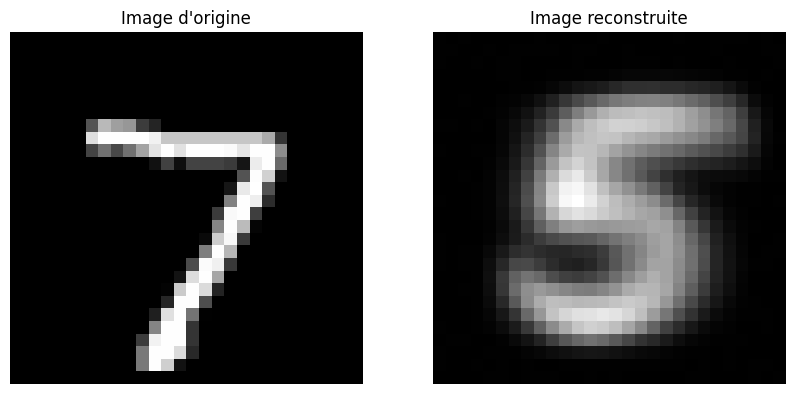

difference :  0.06857609003782272


In [246]:
images,_=next(iter(test_loader))

#Isolons un élément 
image=images[0].unsqueeze(0)
with torch.no_grad():
    recons=model(image)
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Image d'origine
axs[0].imshow(image[0].squeeze().cpu().numpy(), cmap='gray')
axs[0].set_title('Image d\'origine')
axs[0].axis('off')

# Image reconstruite
axs[1].imshow(recons[0].squeeze().cpu().numpy(), cmap='gray')
axs[1].set_title('Image reconstruite')
axs[1].axis('off')
plt.show()
print("difference : ", criterion(image,recons).item())

On constate que la reconstruction du 7 est très mauvaise, on peut donc déduire qu'il s'agit d'une anomalie. 